# Dispersion Measure and Dedispersion

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u

from dedispersionTools import (
    plot_pulseAmplitudes,
    getChannelTOA,
    dedisperse,
    significance,
    DMSearch,
    plot_X2s
)

%matplotlib notebook

## Introduction ##

Pulses that travel through the ISM are subject to a number of effects, all of which can change the estimated times-of-arrival (TOAs) and affect any other signal we are trying to detect. The most prominent effect on timing comes from pulses traveling through the cold, ionized plasma of the ISM. The index of refraction of the medium is frequency-dependent, resulting in lower frequencies arriving later at the telescope than higher frequencies. The amount of time that a signal will be shifted by is given by
$$
t_{\mathrm{DM}}=4.15\,\mathrm{ms}\Bigl(\frac{\nu}{\mathrm{GHz}}\Bigr)^{-2}\biggr(\frac{\mathrm{DM}}{\mathrm{pc}\,\mathrm{cm^{-3}}}\biggl),
$$
where DM is the dispersion measure, the integral of the electron number density, $n_e$, along the line of sight to the pulsar (a distance $D$ away):
$$
\mathrm{DM}=\int_0^D n_e\,d\ell.
$$
Because every frequency is shifted by an amount proportional to the DM, one can determine the DM by measuring the relative delay between two different frequencies $\nu_1$ and $\nu_2$, which is given by
$$
\Delta t_{\mathrm{DM}}=4.15\,\mathrm{ms}\biggl[\Bigl(\frac{\nu_1}{\mathrm{GHz}}\Bigr)^{-2}-\Bigl(\frac{\nu_2}{\mathrm{GHz}}\Bigr)^{-2}\biggr]\biggr(\frac{\mathrm{DM}}{\mathrm{pc}\,\mathrm{cm^{-3}}}\biggl).
$$
Therefore, by measuring the TOAs at two different frequencies, we can estimate the dispersion measure, remove the effect, and improve the overall timing of the pulsar.

In this activity, you'll be applying dedispersion to real pulsar observations taken by the Green Bank radio telescope. Eventually, you'll be able to use the dispersion measures you find to estimate the value of $n_e$ in the ISM.

## Loading the data

Let's start by loading the data into memory. This repository contains several data files in `.npz` format, which can be loaded using the `np.load()` function. You should be able to run the analysis in this notebook on any of the following five data sets, which are located in the `dataFiles/` directory:
1. Set 1: `J1713+0747.GBT.npz`
2. Set 2: `J1455-3330.GBT.npz`
3. Set 3: `J1600-3053.GBT.npz`
4. Set 4: `J1643-1224.GBT.npz`
5. Set 5: `J2145-0750.GBT.npz`

Each of these is an observation of a different pulsar. The first part of the file name is the pulsar's name or "phone number", which is derived from its right ascension (in hours and minutes) and declination (in degrees and minutes). The letter "J" means that the coordinates are in the J2000 coordinate system. For example, PSR J1713+0747 is located at an RA of 17h 13m and a declination of +7° 47'. We'll use it as our test case.

In [2]:
dataset = np.load("dataFiles/J1713+0747.GBT.npz")

data = dataset['data']      # 2D array of intensity values
period = dataset['period']  # period in seconds
freqs = dataset['freqs']    # frequency in MHz

n_freq = data.shape[0]      # number of frequency channels
n_phase = data.shape[1]     # number of phase bins
period_ms = period*1000     # convert to milliseconds
freqs = freqs/1000          # convert to GHz

# Create an evenly-spaced array of phase values (in milliseconds)
bins = np.linspace(0, period_ms, n_phase, endpoint=False)

Use `plot_pulseAmplitudes(data, bins, freqs)` to visualize any grid of intensity data as a function of frequency and phase. The bottom panel shows the collapsed time series when you sum over all frequencies. At the top, you can see the signal to noise ratio (S/N or SNR) and $\sigma_{\mathrm{TOA}}$, the TOA uncertainty (in ms), when you fit a Gaussian pulse.

<IPython.core.display.Javascript object>


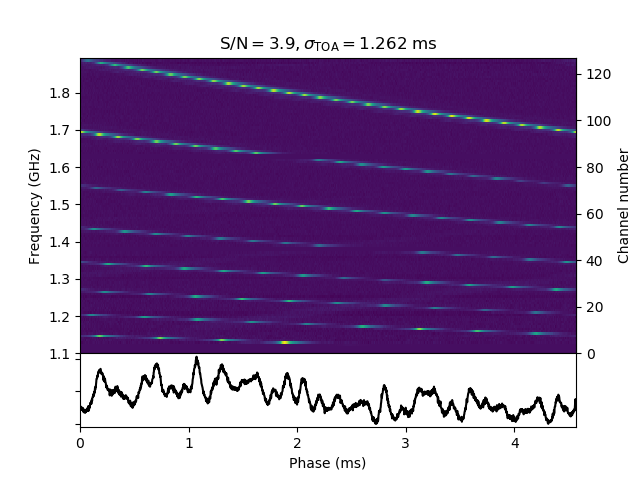

In [3]:
plot_pulseAmplitudes(data, bins, freqs)

You can visualize any single frequency profile using `plt.plot(data[freqChannel])`, where `freqChannel` is an integer between 0 and one less than the number of frequency channels (`len(data)` or`data.shape[0]`). For the J1713+0747 dataset, there are 128 frequency channels, so `freqChannel` must be between 0 and 127.

<IPython.core.display.Javascript object>


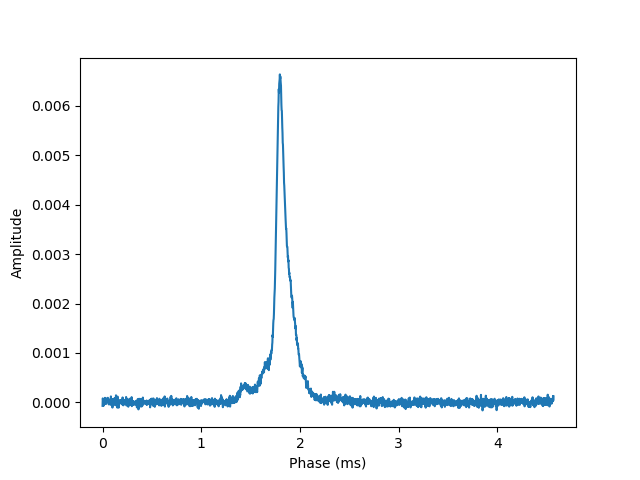

In [4]:
plt.plot(bins, data[64])
plt.xlabel('Phase (ms)')
plt.ylabel('Amplitude')
plt.show()

## Calculating TOAs

The function `getChannelTOA(data, bins, freqChannel)` calculates the value of the time-of-arrival of a pulse in pulse phase. Try this out for a few different channels. The return value is in milliseconds.

In [5]:
getChannelTOA(data, bins, 64)

1.8099265547171683

Here we go through systematically and compute the TOA for each frequency channel in order to make a plot.

In [6]:
toas = np.empty_like(freqs)

for i in range(data.shape[0]):
    try:
        if np.all(data[i] == 0):
            raise IndexError
        toas[i] = getChannelTOA(data, bins, i)
    except IndexError:
        toas[i] = np.nan

Notice that there is a general decreasing trend as the frequency increases, since higher frequencies are delayed less, but that it's interrupted by vertical jumps when the phase wraps around a full cycle.

<IPython.core.display.Javascript object>


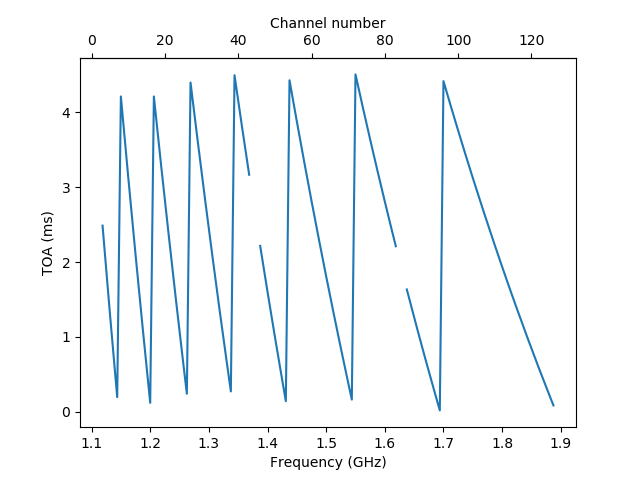

In [7]:
fig, ax = plt.subplots()
ax.plot(freqs, toas)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('TOA (ms)')

dt = freqs[1] - freqs[0]

def freq2chan(freq):
    chan = (freq - freqs[0])/dt
    return chan

def chan2freq(chan):
    freq = freqs[0] + chan*dt
    return freq

ax2 = ax.secondary_xaxis('top', functions=(freq2chan, chan2freq))
ax2.set_xlabel('Channel number')
plt.show()

## Determining the DM

You can get an estimate of the DM by looking at the time difference between two frequencies. Choose two frequencies that close enough that they aren't separated by a phase wrap. The numbers below work for the first data set, but not necessarily for the others.

In [8]:
timeDiff = toas[120] - toas[100]
freqHigh = freqs[120]
freqLow = freqs[100]

DM = timeDiff/(4.15*(freqHigh**-2 - freqLow**-2)); DM

15.98958825992196

## De-dispersing the data

The function `dedisperse(data, bins, freqs, trialDM)` performs channel-by-channel dedispersion with a given trial dispersion measure, `trialDM`. The output array, `dedispersedData`, will be the same shape as the original data array, so it can also be plotted with `plot_pulseAmplitudes()`.

In [11]:
dedispersedData = dedisperse(data, bins, freqs, DM)

<IPython.core.display.Javascript object>


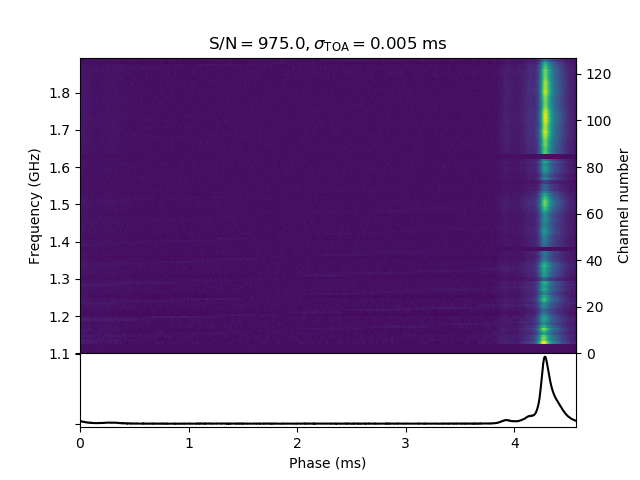

In [12]:
plot_pulseAmplitudes(dedispersedData, bins, freqs)

You may find the `significance()` function useful when trying to hone in on the best DM for your data set. Dedisperse the data according to some trial DM and feed the dedispersed values into this function. It will return a signal-to-noise ratio --- the bigger the number, the more closely the pulses in different frequency bands overlap with each other. If you change the trial DM with which you dedisperse the data and this number gets bigger, you're moving the trial DM in the right direction.

In [13]:
significance(dedispersedData)

974.9563015185338

## Searching over DM

You can use function `DMSearch(data, bins, freqs, DMLB, DMUB, nDM)` to really zero in on the pulsar's DM. Given a lower bound on the DM (`DMLB`) and an upper bound (`DMUB`), this function will assess the significance of folding the data according to `nDM` different DMs, equally spaced between the lower bound and the upper bound.

In [14]:
trialDMs, sns = DMSearch(data, bins, freqs, DMLB=15, DMUB=17, nDM=128)

0.78125% complete
1.5625% complete
2.34375% complete
3.125% complete
3.90625% complete
4.6875% complete
5.46875% complete
6.25% complete
7.03125% complete
7.8125% complete
8.59375% complete
9.375% complete
10.15625% complete
10.9375% complete
11.71875% complete
12.5% complete
13.28125% complete
14.0625% complete
14.84375% complete
15.625% complete
16.40625% complete
17.1875% complete
17.96875% complete
18.75% complete
19.53125% complete
20.3125% complete
21.09375% complete
21.875% complete
22.65625% complete
23.4375% complete
24.21875% complete
25.0% complete
25.78125% complete
26.5625% complete
27.34375% complete
28.125% complete
28.90625% complete
29.6875% complete
30.46875% complete
31.25% complete
32.03125% complete
32.8125% complete
33.59375% complete
34.375% complete
35.15625% complete
35.9375% complete
36.71875% complete
37.5% complete
38.28125% complete
39.0625% complete
39.84375% complete
40.625% complete
41.40625% complete
42.1875% complete
42.96875% complete
43.75% complete


You can visualize the results of a DM search with the function `plot_X2s(trialDMs, sns)`, which plots the output of `DMSearch()`. Look for a peak in the S/N values as an indicator of the best DM at which to dedisperse the data.

<IPython.core.display.Javascript object>


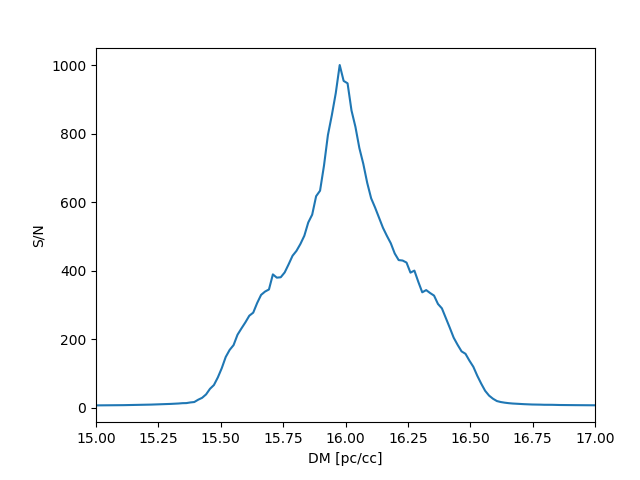

In [15]:
plot_X2s(trialDMs, sns)

In [16]:
bestDM = trialDMs[np.argmax(sns)]; bestDM

15.976377952755906

## Estimating the electron density

Finally, try using the DM you found to estimate the electron density in the interstellar medium. All of the pulsars used in this activity have measured parallaxes (with varying degrees of precision!), which you can find on [Shami's website](http://hosting.astro.cornell.edu/research/parallax/). Try converting your pulsar's parallax to a distance and using it to estimate the average electron density along its line of sight. You can do the calculations in this notebook if you want; it's a great use case for the `astropy.units`. Here's the result for J1713+0747, using the parallax from Chatterjee et al. (2009):

In [17]:
parallax = 0.95/u.kpc
distance = 1/parallax
n_e = (bestDM*u.pc/u.cm**3)/distance
n_e.to(u.cm**-3)

<Quantity 0.01517756 1 / cm3>